# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

## Описание данных

В файле `games.csv` собраны исторические данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы

- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB 

ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Возможные значения рейтинга (источники - [ESRB](https://www.esrb.org/ratings-guide/), [Википедия](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board))

- `EC` (**Early Childhood**) - «_Для детей младшего возраста_»: для детей от 3 лет
- `E` (**Everyone**) - «_Для всех_»: для возрастной категории от 6 лет
- `E10+` (**Everyone 10+**) - «_Для всех от 10 лет и старше_»
- `T` (**Teen**) - «_Подросткам_»: для лиц от 13 лет
- `M` (**Mature**) - «_Для взрослых_»: не подходит для подростков младше 17 лет
- `AO` (**Adults Only 18+**) - «_Только для взрослых_»: для взрослых старше 18 лет
- `RP` (**Rating Pending**) - «_Рейтинг ожидается_»: продукт ожидает присвоения рейтинга

Данные за 2016 год могут быть неполными.


## Библиотеки и настройки

In [1]:
# для формтированного вывода
from IPython.display import Markdown, display 

# для работы с данными
import pandas as pd

# для вычислений
import numpy as np
import math as mt
from scipy import stats as st

# для графиков
import seaborn as sns
from matplotlib import pyplot as plt

# для работы с регулярными выражениями
import re

# КОНСТАНТЫ
# Паттерн для распознавания года в названии игры
YYYY_PATTERN = r'((?:19[89]|20[01])[0-9])'  # от 1980 до 2019
YY_PATTERN   = r'((?:[89]|[01])[0-9])'      # от  '80 до  '19
# Паттерн для распознавания знаков пунктуации, за исключением скобок
PUNCT_PATTERN = r'[^\w\s]'
#pd.set_option('display.float_format', '{:.2f}'.format)

# при выводе датафрейма будем показывать все колонки
pd.set_option('display.max_columns', None)
# зададим некоторые параметры по умолчанию для графиков 
# sns.set(rc={'figure.figsize':(12,8)})
plt.rcParams.update({
    'axes.titlesize': 14,
    'figure.figsize': (12, 8)})

## Функции

In [2]:
# функция вывода списка по колонкам
def print_list_by_columns(list_to_print, col_num = 3, col_width = 50):
    """ Печать элементов списка или массива по столбцам 
    
    Параметры:
        col_num : int - количество столбцов  
        col_width : int - ширина столбца в символах 
    """
    # количество строк для вывода, 
    # если размер списка не кратен количеству колонок, добавим одну строку
    lines_num = (len(list_to_print) // col_num) + (len(list_to_print) % col_num > 0)
    # вывод на экран построчно столбцов шириной col_width
    for i in range(lines_num):
        line_to_print = ''
        for elem in list_to_print[i::lines_num]: 
            line_to_print += elem.ljust(col_width)
        print(line_to_print)

# Матрица рассеяния
def show_scatter_matrix(df, cols, title='Матрица рассеяния', alpha=1.0, figsize=(12,10)):
    ''' Матрицы рассеяния для колонок cols из датасета df

    Параметры:
        df : pd.DataFrame - датасет, для которого строим матрицу  
        cols : list - список столбцов датасета 
        title : str - текст названия графика (необязательный)
        alpha, figsize - аргументы plot (необязательные)
    '''
    # строим матрицы рассеяния и гистограммы
    pd.plotting.scatter_matrix(df[cols], alpha=alpha, figsize=figsize);
    plt.suptitle(title, fontsize=14, y=0.92)

# Стилизованная матрица коррелляции
def styled_corr(df, cols, precision=2):
    ''' Матрица коррелляции для колонок cols из датасета df

    Параметры:
        df : pd.DataFrame - датасет, для которого вычисляем матрицу  
        cols : list - список столбцов датасета
        precision : int - количество знаков после запятой (необязательный) 
        first_to_others : bool - флаг, если True выводит только коэффициенты 
        между первым столбцом и остальными, пераданными в cols
    '''
    return (
        df[cols].corr()
        .style.background_gradient(cmap='coolwarm') #, vmin=-1, vmax=1) в pandas=0.25 не работает
        .set_precision(precision)
    ) 

# Изучение и подготовка данных

## Изучение датасета

Загрузим датасет, посмотрим информацию о нём

In [3]:
try: # eсли ноутбук запускается на локальном ПК, то читаем данные из файла в директории
    df = pd.read_csv('games.csv')
except: # если в Jupyter Hub Яндекс.Практикума
    df = pd.read_csv('/datasets/games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Берём на заметку
- Есть 2 игры без названия и жанра, около 300 пропусков в значениях года релиза. 
- Значительная доля пропущенных значений в колонках оценки критиков, оценки пользователей и рейтинга ESRB.
- Тип данных года релиза - `float`, следует поменять на `int`, однако пока там есть пропуски мы этого сделать не сможем.
- Тип данных оценки пользователей - `object`, значит скорее всего содержит строковые значения 

## Подготовка датасета

Приведём названия колонок к нижнему регистру, проверим на наличие явных дублей, выведем первые и последние строки

In [4]:
df.columns = df.columns.str.lower()
display(Markdown('Количество явных дублей: {}'.format(df.duplicated().sum())))
df

Количество явных дублей: 0

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Дублей не выявили. Устраним вышеобозначенные проблемы.

Прежде составим справочник с диапазоном выпуска годов и количеством игр для разных платформ. Будем в последующем обращаться к этой таблице как к стравочнику

In [5]:
platforms = ( df[['platform','name','year_of_release']]
    .pivot_table(index='platform', aggfunc={'name':'count','year_of_release':['min','median','max']})
    .round().astype('int').droplevel(0,axis=1)
    .rename(columns={'min':'year_min','median':'year_median','max':'year_max'})
    .sort_values(by=['year_max','year_min'],ascending=False)
)
platforms.head(15)

,count,year_max,year_median,year_min
platform,,,,
PS4,392,2016,2015,2013
XOne,247,2016,2015,2013
WiiU,147,2016,2013,2012
3DS,520,2016,2013,2011
PSV,430,2016,2014,2011
PS3,1331,2016,2011,2006
Wii,1320,2016,2009,2006
X360,1262,2016,2010,2005
PC,974,2016,2010,1985


Видим, что на большую часть встречающихся платформ, игры уже не выпускаются. У каждой платформы есть своё "время жизни". Кроме персональных компьютеров (PC)

### Названия игр. Обработка дублей

Посмотрим на строки игр с неизвестными именами из основной таблицы

In [6]:
display(df[df.name.isna()])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Обе игры с пропущенными именами для старой платформы, на которую игры уже не выпускаются, просто удалим их, для анализа на 2017 год они очевидно интереса не представляют 

In [7]:
df.dropna(subset=['name'],inplace=True)
df.reset_index(drop=True);

При беглом промотре таблицы было обнаружено, что у некоторых игр в названии в скобках указаны комментарии. Посмотрим на часть игр, в названии которых встречаюся скобки. 

Делаем это для проверки наличия дублей в названиях.

In [8]:
if  df[df['name'].str.contains('(',regex=False)].equals(
    df[df['name'].str.contains(')',regex=False)]):
    print('Скобки в названиях игр всегда парные')

df[df['name'].str.contains('(',regex=False)].sample(5)


Скобки в названиях игр всегда парные


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14558,Lux-Pain (JP sales),DS,2008.0,Adventure,0.00,0.00,0.03,0.00,NaN,NaN,NaN
9685,F1 2016 (Codemasters),XOne,2016.0,Racing,0.03,0.08,0.00,0.01,NaN,NaN,NaN
1467,Ratchet & Clank: Up Your Arsenal (Weekly ameri...,PS2,2004.0,Platform,1.27,0.05,0.00,0.02,NaN,NaN,NaN
9327,GoldenEye 007 (2010),DS,2010.0,Action,0.10,0.03,0.00,0.01,NaN,NaN,NaN
13345,Rain (2013),PS3,2013.0,Adventure,0.00,0.00,0.05,0.00,NaN,NaN,NaN


Пример замеченного дубля

In [9]:
df[df['name'].str.contains("Tony Hawk's American Wasteland")]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1136,Tony Hawk's American Wasteland (Old all region...,PS2,2005.0,Sports,0.80,0.63,0.01,0.19,NaN,NaN,NaN
1324,Tony Hawk's American Wasteland (Weekly america...,PS2,2005.0,Sports,1.38,0.05,0.00,0.02,NaN,NaN,NaN
3224,Tony Hawk's American Wasteland,XB,2005.0,Sports,0.40,0.20,0.00,0.03,77.0,7.7,T
4564,Tony Hawk's American Wasteland,GC,2005.0,Sports,0.33,0.08,0.00,0.01,76.0,7.7,T
5597,Tony Hawk's American Wasteland,X360,2005.0,Sports,0.28,0.01,0.00,0.03,75.0,7.2,T


Посмотрим, какого типа встречаются комментарии, чтобы понять, как их можно обработать. Приводим всё в нижний регистр, чтобы исключить повторения.

In [10]:
# создаём список с встречающимися комментариями
comments = list(map(
    lambda name: name[name.find('(')+1:name.find(')')],
    df[df['name'].str.contains('(',regex=False)]['name'].str.lower()
))
# выводим количество
print('Строк с комментариями:', len(comments))
# с помощью set сохраняем только уникальные значения? выводми
comments = sorted(list(set(comments)))
print_list_by_columns(comments, col_width=35)

Строк с комментариями: 279
2006                               ds version                         online edition                     
2008                               ds versions                        others sales                       
2009                               ebkore+                            pal                                
2010                               gbc                                ps1 & psp versions                 
2012                               higher jp sales                    psp                                
2013                               insomniac                          red                                
2014                               japan                              remake                             
2015                               japan sales                        rp-m                               
2016                               joukan                             rp-t                               
3ds                

Замечаем

- В некоторых случаях в скобках указан год - это может быть переиздание игры, формально это будет новой игрой, такие имена не будем трогать.

- Чаще всего встречаются комментарии со словом `sales`. По ним понятно, что для некоторых игр в комментариях указывается, для какого региона указаны продажи. Такие строки можно объеденить со строками игр, не имеющих комментариев. Однако по некторым возникают вопросы: неясно, что имеется в виду под старыми и еженедельными продажами, также есть комментарии, в которых написано, что указаны неверные единицы. 

- В некоторых указана версия платформы, такие комментарии бессмысленны, так как в таблице есть отдельная колонка, в которой указана платформа. Можно удалить

Об этих проблемах лучше сообщить заказчику, уточнить правильные данные. Но для ответа на поставленные вопросы столь маленькая выборка не повлияет на конечные выводы, К тому же не стоит задачи анализа отдельных игр. 

Зададим корректное имя для каждой игры, удалив лишние пробелы и обнаруженные комментарии. Для этого напишем функцию. 
Исключать будкм только записи со словом `sales`, названиями региона и платформ. Остальное оставим без изменений.

In [11]:
# функция извлечения комментария
def set_correct_name(row, keywords=[]):
    """ Убирает комментарий, заключённый в скобки, из строки элемента row['name'] 
        на основе списка ключевых слов, убирает лишние пробелы
    
    Параметры:
        row : строка pd.DataFrame
        keywords : список ключевых слов

    Возвращает:
        отформатированное значение строки name
    """
    name = re.sub(' +',' ',row['name']).lstrip().rstrip()
    if '(' in name:
        comment = name[name.find('(')+1 : name.find(')')].lower()
        if any(key in comment for key in keywords):
            return name[ : name.find('(')].rstrip()   
        else:
            return name
    else:
        return name

# список с ключевыми словами:
# названия платформ в нижнем регистре
keywords = list(platforms.index.str.lower())
# другие ключевые слова
keywords.extend(['sales','jp','japan','america'])

# применяем функцию
df['name'] = df.apply(set_correct_name, keywords=keywords, axis=1)

Возможны также неявные дубли в названиях игр, связанные с использованием знаков пунктуации. Напишем функцию, которая будет выявлять неявные дубли, вызванные применением разных знаков пунктуации и возвращать `pd.Series`, в которой в качестве индексов сохраняются уникальные значения строк из переданного столбца, в качестве значений - единообразная форма написания

In [12]:
def unified_series(col, pat, show_dupl=False):
    """ Функция возвращает pd.Series с уникальными написаниями названий из столбца col. \\
    Все строки переводятся в нижний регистр с удалением лишних символов на основе паттерна pat \\ 
    и лишних пробелов, затем сортируются, на основе них выявляются повторяющиеся значения 
    
    Параметры:
        col : pd.Series - столбец для поиска дублей, также служит индексом для возвращаемой серии
        pat : str - RegEx паттерн для распознавания исмволов, подлежащих удалению
        display_duplicates : boolean - флаг, отображать ли найденные дубликаты

    Возвращает:
        pd.Series 
    """
    
    list_to_correct = list(col.unique())
    # список в унифицированном формате
    list_unified = list(map(lambda elem: 
        ' '.join(re.sub(pat,' ', elem.lower()).split()), list_to_correct
    ))
    # сортированные списки
    list_sorted = [x for _,x in sorted(zip(list_unified, list_to_correct))]
    list_unified = sorted(list_unified)


    list_to_save = []       # список, который вернём в серии
    list_duplicates = []    # список всех дубликатов
    names = []              # список дублей для одной игры
    prev = ''               # строка из предыдущей итерации
    count = 0               # счётчик дублей
    for i in range(len(list_sorted)):
        if list_unified[i] == prev:
            count += 1
            names.append(list_sorted[i-1])
            list_to_save.append(list_to_save[-1])
        else:
            if count > 1:
                names.append(list_sorted[i-1])
                list_duplicates.append(names)
            count = 1
            names = []
            list_to_save.append(list_sorted[i])       
        prev = list_unified[i]
    
    # выводим дубликаты, если указан флаг
    if show_dupl:    
        display(list_duplicates)

    display(Markdown('Количество повторяющихся игр с разным написанием названия: **{}**'
                     .format(len(list_duplicates))))
    return pd.Series(list_to_save, index=list_sorted)

# заменяем имена
df['name'] = df['name'].map(unified_series(df['name'], PUNCT_PATTERN, show_dupl=False))
# посмотрим на дубликаты по паре значений название-платформа
df[df.duplicated(['name','platform'], keep=False)].sort_values('name').head()

Количество повторяющихся игр с разным написанием названия: **32**

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
8597,.hack//G.U. Vol.2//Reminisce,PS2,2006.0,Role-Playing,0.00,0.00,0.16,0.00,NaN,NaN,NaN
7087,.hack//G.U. Vol.2//Reminisce,PS2,2006.0,Role-Playing,0.11,0.09,0.00,0.03,NaN,NaN,NaN
5455,Ape Escape Academy,PSP,2004.0,Misc,0.13,0.15,0.00,0.05,51.0,5.8,E10+
9249,Ape Escape Academy,PSP,2004.0,Misc,0.00,0.00,0.13,0.00,NaN,NaN,NaN
5979,Atelier Iris 3: Grand Phantasm,PS2,2006.0,Role-Playing,0.14,0.11,0.00,0.04,NaN,NaN,NaN


Для одного и того же дубля в некоторых столбцах значение может отсутсвовать. Теперь обработаем дубли так, чтобы сохранить информацию. Найдём строки, дублирующиеся по паре значений _название-платформа_, сгруппируем по ним все значения и применим к каждому столбцу функции через `agg` к столбцам:
- с _годом выпуска, жанром, оценками и райтингом_: `first` - так останется первое значение, отличное от NaN.
- с _продажами_: `sum` - так продажи, учтённые отдельной строкой, добавятся к сгруппированной отдельной

полученнымми "правильными" строками заменим те, которые содержали дубли.

In [13]:
# объединение дублей с сохранением информации
joined_duplicates = ( df[df.duplicated(['name','platform'], keep=False)]
    .sort_values('name').groupby(['name','platform']).agg({
        'year_of_release'   : 'first',
        'genre'             : 'first',
        'na_sales'          : 'sum',
        'eu_sales'          : 'sum',
        'jp_sales'          : 'sum',
        'other_sales'       : 'sum',
        'critic_score'      : 'first',
        'critic_score'      : 'first',
        'rating'            : 'first'
    })
).reset_index()

# удаление старых строк с дублями, добавление новых объединённых строк
df = (df.drop_duplicates(subset=['name','platform'], keep=False)
        .append(joined_duplicates, ignore_index=True, sort=False)
)

### Обработка пропусков 

Проверим, представлена ли одна и та же игра на разных платформах. Сразу подготовим вспомогательную таблицу, которая поможет частично заполнить пропуски в значениях года выпуска. Для этого подсчитаем у игр, которые выпущены более, чем на одной платформе, количество значений в столбцах платформы и года и среднее по году. Отфильтруем те игры, у которых есть пропуск значения года в строке с какой либо платформой. Для разных платформ год может быть разным, но в среднем не должен сильно меняться.

In [14]:
# создаём сводную таблицу
games_platforms_and_years = ( df[['name','platform','year_of_release']]
    .pivot_table(index='name', 
                 aggfunc={'platform':'count','year_of_release':['count','mean']})
)
# меняем названия столбцов
games_platforms_and_years.columns = ['platform_cnt', 'year_cnt', 'year_mean']
# применяем фильтры
games_platforms_and_years = games_platforms_and_years.query(
    'platform_cnt > 1 and platform_cnt > year_cnt and year_mean == year_mean')
# выводим таблицу
games_platforms_and_years.sort_values(by='platform_cnt', ascending=False).head()

,platform_cnt,year_cnt,year_mean
name,,,
Madden NFL 07,9,8,2006.0
LEGO Harry Potter: Years 5-7,8,1,2012.0
Madden NFL 06,7,6,2005.0
LEGO Indiana Jones: The Original Adventures,7,6,2008.0
LEGO Batman: The Videogame,7,5,2008.0


В таблице видим, что одна игра может быть представлена на нескольких платформах, Действительно, есть игры, у которых год выпуска предствален не для всех платформ. Также можно было заметить, что у некоторых игр в названии есть год.

1. Присвоим играм с пропусками в годе выпуска среднее значение года выпуска на других платформах с помощью метода `map` на основе значений `year_mean` из полученной таблицы

2. Часть пропусков можно заполнить значением года в названии. Хотя год в названии может не совпадать с годом выпуска, ошибка будет не большой.

3. Оставшиеся значения заполним медианными значением года выпуска по платформе, полагая, что период выпуска на одну и ту же платформу меньше, чем весь исследуемы период.

In [15]:
def fill_year_from_name(row, pat):
    ''' функция присваивает год выпуска игры на основе её названия в строке row

    Параметры:
        row : строка pd.DataFrame
        pattern : str - RegEx паттерн на основе которого распознаётся год

    Возвращает:
        int : значение года, если он найден
        None : если год не найден
    '''
    # поиск года в строке
    year = re.findall(pat, row['name'])
    # если найден - возвращаем
    if year: 
        return int(year[-1])

print("Игр с пропущенным значением года выпуска: ", 
      df['year_of_release'].isna().sum())

# TODO переделать на transform
# ШАГ 1. Заменяем пропуски в годе выпуска средним по 
#        известным значениям года для той же игры
df['year_of_release'] = df['year_of_release'].fillna(
    df.groupby('name')['year_of_release'].transform('mean'))
print("        после заполнения средним по игре: ", 
      df['year_of_release'].isna().sum())

# ШАГ 2. Заменяем пропуске в годе выпуска годом из названия на основе паттерна
#        с помощью функции, применим только для 4-х значного формата года       
df.loc[df['year_of_release'].isna(), 'year_of_release'] = (
    df.loc[df['year_of_release'].isna()]
      .apply(fill_year_from_name, pat=YYYY_PATTERN, axis=1) 
)
print("      после заполнения годом из названия: ", 
      df['year_of_release'].isna().sum())

# TODO переделать на transform
# ШАГ 3. Заменяем пропуски в годе выпуска медианным по 
#        значениям года выпоска в рамках той же платформы
df['year_of_release'] = df['year_of_release'].fillna(
    df.groupby('platform')['year_of_release'].transform('median'))

print(" после заполнения медианным по платформе: ", 
      df['year_of_release'].isna().sum())

Игр с пропущенным значением года выпуска:  262
        после заполнения средним по игре:  140
      после заполнения годом из названия:  134
 после заполнения медианным по платформе:  0


Пропуски, в значениях года выпуска заполнили

Посмотрим, какие строковые значения встречаются в колонке `user_score` 

In [16]:
print('Строковые значения в колонке оценок пользователей: ')
# пробежимся по уникальным значениям строк в поле user_score
# проверим являютсе ли значение в строке числом
# прежде уберём точки
for val in list(df['user_score'].dropna().unique()):
    if not val.replace('.','',1).isdigit():
        print(val)

Строковые значения в колонке оценок пользователей: 
tbd


**tbd** - аббревиатура для "To Be Determined" (_Подлежит уточнению_), значит для таких значений рейтинг не определён, заменим на `nan`

In [17]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

Посмотрим на уникальные значения рейтинга и на количество пропусков

In [18]:
print('Встречающиеся значения рейтинга:', list(df[df['rating'].notna()]['rating'].unique()))
print('Пропусков в значениях рейтинга:', df['rating'].isna().sum())

Встречающиеся значения рейтинга: ['E', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP']
Пропусков в значениях рейтинга: 6640


**K-A** - "Kids to Adults" - устаревшее обозначение рейтинга **E**. Заменим его. 

Для одной и той же игры, выпущенной на разных платформах, рейтинг должен быть одинков. Поэтому пропущенные значения в этом столбце заменим первым отличным от NaN для той же игры.

In [19]:
# заменяем устаревшую аббревиатуру на новую
df.loc[df['rating']=='K-A', 'rating'] = 'E'
# заполняем пропуски
df['rating'] = df['rating'].fillna(df.groupby('name')['rating'].transform('first'))
print('Пропусков в значениях рейтинга:', df['rating'].isna().sum())

Пропусков в значениях рейтинга: 6175


Пропуски в остальных столбцах заполнять не будем. Можно было бы взять среднюю оценку для одной игры по разным платформам, но достоверно восстановить значение оценок критиков и пользователей не получится, поскольку на разных платформах могут быть абсолютно разные оценки из-за особенностей поведения на конкретной платформе, например, в результате портирования. Кроме того, нам необходимо будет оценить, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков, такое заполнение пропусков может исказить выводы.

### Суммарные продажи. Приведение типов данных.

Посчитаем суммарные продажи во всех регионах, запишем в столбец `total_sales`

In [20]:
df['total_sales'] = df.loc[:,'na_sales':'other_sales'].sum(axis=1)

Приведём типы данных:
- Год в целочисленный тип
- оценку пользователей в вещественный 

In [21]:
df['year_of_release'] = df['year_of_release'].round().astype('int')
df['user_score'] = df['user_score'].astype('float')
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16584 entries, 0 to 16583
Data columns (total 12 columns):
name               16584 non-null object
platform           16584 non-null object
year_of_release    16584 non-null int32
genre              16584 non-null object
na_sales           16584 non-null float64
eu_sales           16584 non-null float64
jp_sales           16584 non-null float64
other_sales        16584 non-null float64
critic_score       8132 non-null float64
user_score         7516 non-null float64
rating             10409 non-null object
total_sales        16584 non-null float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15551,Clover no Kuni no Alice: Wonderful Wonder World,PSP,2011,Adventure,0.00,0.00,0.02,0.00,NaN,NaN,NaN,0.02
3138,Tony Hawk's Pro Skater 2x,XB,2001,Sports,0.41,0.19,0.00,0.03,78.0,8.8,T,0.63
13862,Power Play Pool,DS,2006,Sports,0.03,0.00,0.00,0.00,NaN,NaN,E,0.03
9451,X-Men: Next Dimension,GC,2002,Fighting,0.10,0.03,0.00,0.00,63.0,8.2,T,0.13
9449,Drome Racers,PS2,2002,Racing,0.06,0.05,0.00,0.02,57.0,NaN,E,0.13


# Исследовательский анализ

## Распределения по годам

Посмотрим, сколько игр выпускалось в разные годы

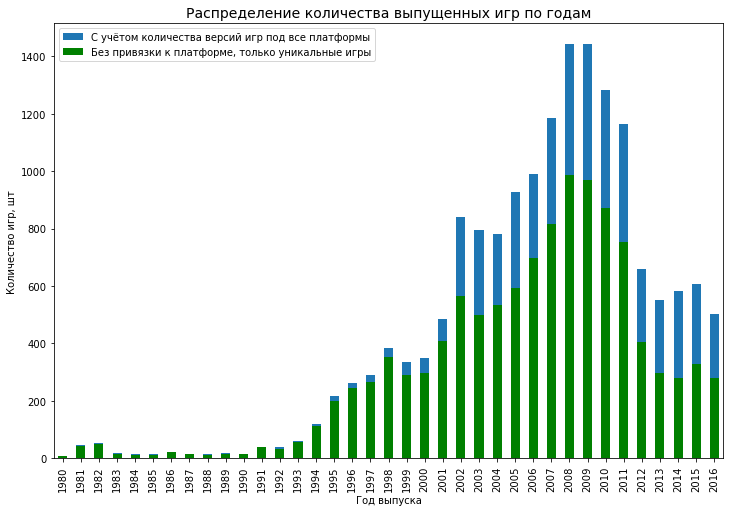

In [22]:
# группируем все записи о играх по году, считаем количество, строим диаграмму
ax = df[['name','year_of_release']].groupby('year_of_release').count().plot(kind='bar')
# делаем то же самое но для датасета предварительно сгруппированного по названиям игр
( df.groupby('name').first().reset_index()[['name','year_of_release']]
    .groupby('year_of_release').count()
    .plot(kind='bar', ax = ax, color='green')
)
# оформляем график
ax.legend([ 'С учётом количества версий игр под все платформы', 
            'Без привязки к платформе, только уникальные игры'])
ax.set(title = 'Распределение количества выпущенных игр по годам',
    xlabel = 'Год выпуска',
    ylabel = 'Количество игр, шт'
);

Из графика видно, что данные за все периоды не важны. Суммарное количество выпущенных игр до 1995 года меньше 100 в год. 

Бросается в глаза спад количества выпускаемых игр с 2010 года. Это может быть связано с несколькими причинами:
- Возросшим интересом к онлайн играм, которые имеют иную схему монетизации, но сами по себе могут быть бесплатны.
- Переход на систему подписок для платформы, когда сами по себе игры не покупаются
- Нельзя исключать возможность того, что в датасете не представлены некоторые платформы, на которые могли переориентироваться разработчики, в том числе мобильные игры.

Переопределим ранее созданную справочную таблицу `platforms` на обновлённом датафрейме. Для каждой платформы поссчитаем суммарное количество проданных копий всех игр, минимальное и максимальное значение года выпуска и их разницу, что позволит оценить время существования платформы. В дальнейшем по необходимости применим к таблице фильтры.

По полученной таблице оценим среднее время жизни платформ. Оценка будет весьма приблизительной, поскольку, на некоторые платформы игры ещё не прекратили выходить после 2016 года, а в наших вычислениях это максимальное значение. Но даже такая грубая оценка позволит нам примерно оценить актуальный период.

,total_sales,lifetime,year_last,year_first
platform,,,,
PS2,1255.77,12,2011,2000
X360,971.42,12,2016,2005
PS3,939.65,12,2016,2005
Wii,907.51,11,2016,2006
DS,806.12,29,2013,1985
PS,730.86,10,2003,1994
GBA,317.85,8,2007,2000
PS4,314.14,4,2016,2013
PSP,294.05,12,2015,2004


Среднее время жизни платформ (в годах): **9.26**

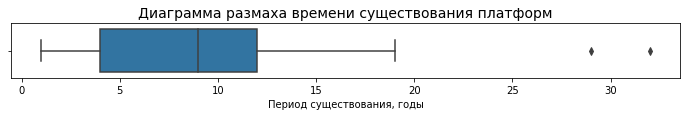

In [23]:
# генерируем сводную таблицу
platforms = ( 
    df[['platform','year_of_release','total_sales']].pivot_table(index='platform', 
        aggfunc={'total_sales':'sum', 
                 'year_of_release':[np.min,np.max,lambda x: np.max(x)-np.min(x)+1]})
    .droplevel(0,axis=1).rename(columns = {
        'amin':'year_first','amax':'year_last',
        '<lambda_0>':'lifetime', 'sum':'total_sales'})
    .sort_values(by='total_sales', ascending=False)
)
# отображаем информацию
display(platforms.head(20))
display(Markdown('Среднее время жизни платформ (в годах): **{:.2f}**'
                 .format(platforms['lifetime'].mean())))
# выводим диаграмму размаха
_, ax = plt.subplots(figsize = (12,1))
sns.boxplot(x = platforms['lifetime'])
ax.set( title = 'Диаграмма размаха времени существования платформ',
        xlabel = 'Период существования, годы'
);

## Актуальный период и потенцильно прибыльные платформы

По грубой оценке в среднем платформы появляются и исчезают в течение 10 лет. Большиство существует до 18 лет. Посмотрим распределение количества проданных копий по платформам и годам. Изобразим это распределение в виде тепловой шкалы, где каждой платформк будет соответсвовать строка, году - столбец. Также упорядочим выводимые платформы на основе сводной таблицы `platforms`, отсортировав по годам выпуска последней и первой игр на платформе. Таким образом, построим временную шкалу существования платформ. Ограничимся 2000 годом

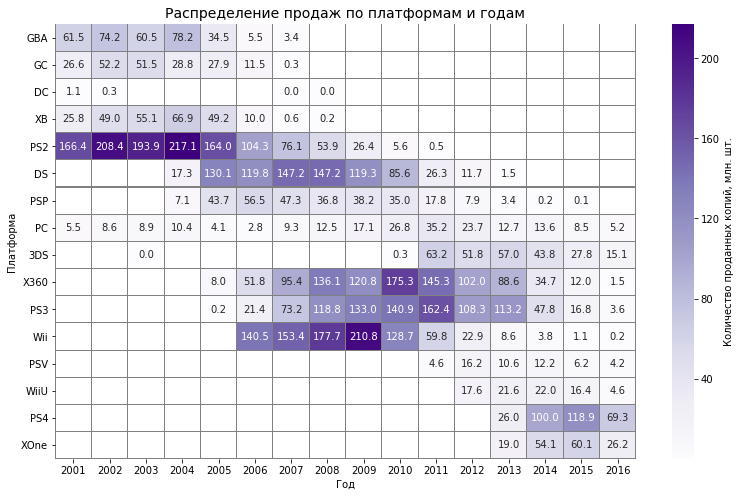

In [24]:
# составим список платформ, на которые выпускались игры в последние 10 лет
p_10_years = platforms[platforms.year_last>2006].sort_values(by=['year_last','year_first']).index

# получим срез данных - таблицу с суммарным количеством проданных копий
# для каждой платформы по годам
sales_by_year_and_platform = ( 
    df.query('2000 < year_of_release and platform in @platforms.index')
        .pivot_table(index='platform', columns='year_of_release', 
                     aggfunc={'total_sales':'sum'})
        .droplevel(0,axis=1)
)
# отсортируем по годам выпуска последней и первой игр
sales_by_year_and_platform = sales_by_year_and_platform.reindex(p_10_years)
# построим heatmap
_, ax = plt.subplots(figsize=(13,8))
sns.heatmap(sales_by_year_and_platform, annot=True, 
            linewidths=0.05, linecolor='grey', fmt='.1f', cmap='Purples',
            cbar_kws={'label': 'Количество проданных копий, млн. шт.'})
ax.set( title='Распределение продаж по платформам и годам',
        xlabel='Год', ylabel='Платформа')
plt.yticks(rotation=0);

Необходимо учитывать, что данные за 2016 год неполные. Этим обусловлен спад продаж у некоторых платформ в последнем году на диаграмме. 

Наглядно видно, какие платформы ещё сохраняют активность, какие - нет.
Логично рассматривать платформы, на которые в 2016 году ещё выпускаются игры.
- Уже можно выделить 2 платформы, набирающие активность - __PS4__ и __XOne__.
- Пик популярности платформы __Wii__ приходился на 2009 год, на 2015 самый низкий из ещё активных 
- Пик для __X360__, __PS3__ приходился на 2010 - 2011 годы, однако для них количество проданных копий весьма велико даже в 2015 году

Выведем графики изменения количества проданных копий игр по годам для платформ, на которые в 2016 году ещё выпускаются игры. Ограничимся диапазоном с 2010 по 2015 год.

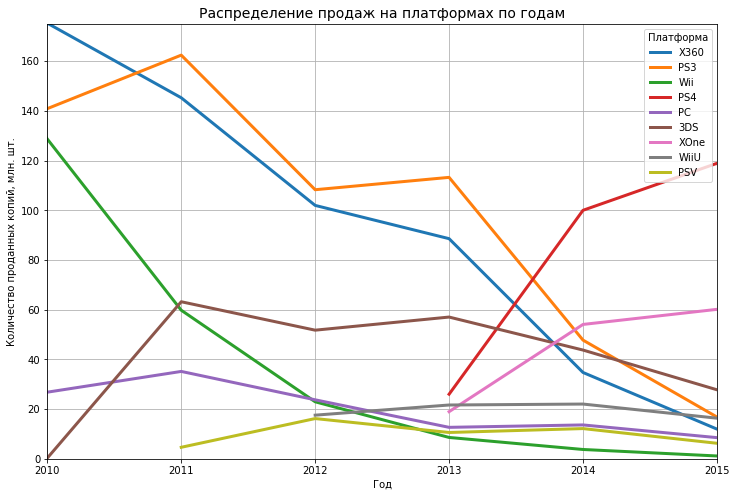

In [25]:
# список платформ, на которые ещё выпускаются игры
p_candidates = platforms[platforms.year_last>2015].index
# построение графика
ax = sales_by_year_and_platform.loc[p_candidates].T.plot(grid=True, linewidth=3)
ax.legend(title='Платформа')
ax.set( title='Распределение продаж на платформах по годам',
        xlabel='Год', ylabel='Количество проданных копий, млн. шт.',
        xlim=(2010,2015), ylim=(0,175)
);

Для построения прогноза на 2017 год _установим актуальный период с 2013 по 2015 год_. Здесь появились 2, набирающие популярность платформы, 2016 год исключаем по причине неполных данных

- В перспективе на ближайшие несколько лет не стоит рассматривать __PS3__ и __X360__ - они испытывают резкий спад, и платформу __Wii__ - она находится на минимуме продаж. Причина в виходе платформ нового поколения. 
- Приемники вышеобозначенных более перспективны. __PS4__ и __XOne__ вообще в этот период растут по продажам. У __WiiU__ спад незначительный
- Не так сильно падают по продажам __3DS__, __PC__, __PSV__. При этом не стоит забывать, что спад этот наблюдается на фоне общего снижения количества выпускаемых игр на всех платформах

Таким образом, в качестве потенциально прибыльных платформ есть смысл рассмотреть
- Однозначно __PS4__ и __XOne__
- Для расширения ассртимента магазина не стоит отбрасывать __3DS__, __WiiU__, __PC__

## Распределение продаж по платформам

,sum,median,mean
platform,,,
PSV,29.00,0.050,0.105839
3DS,128.58,0.090,0.490763
PC,34.81,0.100,0.252246
Wii,13.48,0.165,0.612727
PS3,177.83,0.190,0.579251
WiiU,60.03,0.200,0.594356
X360,135.28,0.290,0.781965
PS4,244.89,0.310,1.074079
XOne,133.17,0.350,0.832312


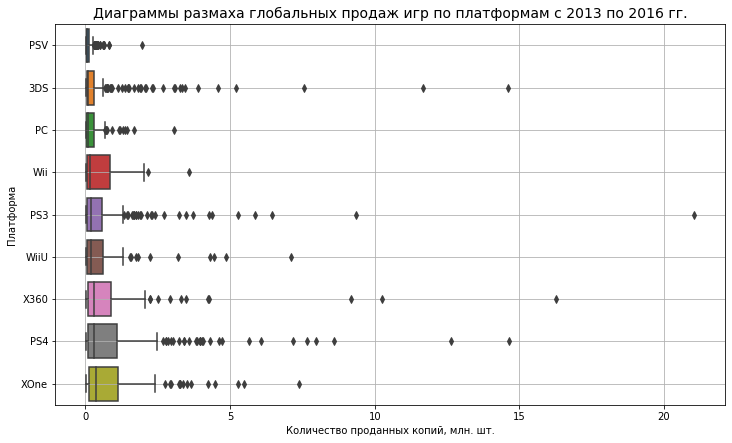

In [26]:
df_actual = df.query("platform in @p_candidates and 2012 < year_of_release < 2016")

# оставим платформы, у которых игры выпускались в 2016 году
p_candidates_sales = df_actual.pivot_table(
        index='platform', values='total_sales', aggfunc=['sum','median','mean']
    ).droplevel(1,axis=1).sort_values(by='median')
display(p_candidates_sales)

# изобразим для них диаграммы размаха продаж отсортировав по медианному значению
_, ax = plt.subplots(figsize=(12,7))
sns.boxplot(x=df_actual.total_sales, y=df_actual.platform, 
            order = p_candidates_sales.index)
ax.set(
    title = 'Диаграммы размаха глобальных продаж игр по платформам с 2013 по 2016 гг.',
    xlabel = 'Количество проданных копий, млн. шт.', ylabel='Платформа'
)
ax.grid()

Очевидна скошенность распределений продаж по всем платформам вправо. Однако не следует интерпретировать очень большие значения, выходящие за пределы диаграммы размаха, как выбросы. Сюда попали наиболее популярные игры. Большая часть пользователей вовсе не приобретает малоизвестные игры.

По этой причине платформы, у которых на данной диаграмме наблюдаем выбросы, потенциально наиболее прибыльны -- продажи популярных игр могут принести бОльшую выручку. 

Построим те же диаграммы размаха, но ограничим диапазон построения по оси продаж до 2,5 миллионов копий. Отобразим также среднее значение

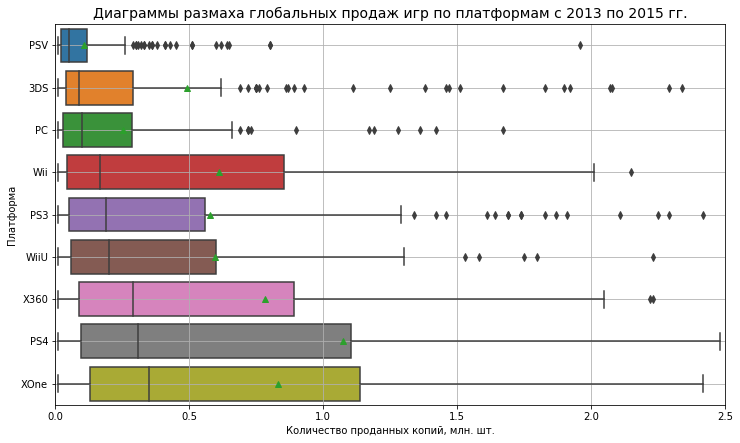

In [27]:
# изобразим для них диаграммы размаха продаж отсортировав по медианному значению
_, ax = plt.subplots(figsize=(12,7))
sns.boxplot(x=df_actual.total_sales, y=df_actual.platform, showmeans=True, 
            order = p_candidates_sales.index)
ax.set( xlim=(0,2.5),
    title = 'Диаграммы размаха глобальных продаж игр по платформам с 2013 по 2015 гг.',
    xlabel = 'Количество проданных копий, млн. шт.', ylabel='Платформа'
)
ax.grid()

- Медианные и средние значения продаж у __PS4__ и __XOne__ - самые высокие.
- Характер распределений для всех платформ схож. У платформ __PS3__ и __3DS__ средние значения даже выше диапазона 3 квартиля. Это может быть связано наличием большого количества эксклюзивных игр под платформу
- Несмотря на высокие значения медианных продаж для __PS3__, __X360__, __Wii__, магазину не стоит их рассматривать, поскольку есть платформы преемники __PS4__, __XOne__, __WiiU__. В большинстве случаев эти платформы поддерживают наиболее популяные игры с платформ предыдущего поколения. А в последующие годы спрос на игры под прудыдущие поколения сведётся к нулю
- Как и полагали ранее, не стоит влючать платформу __PSV__. 

Исключим неперспективные платформы

In [28]:
try:
    p_candidates = p_candidates.drop(['PSV','PS3','X360','Wii'])
except:
    print('Платформы уже удалены')

## Влияние оценок на продажи

Приведём оценки пользователей и критиков к одной системе - десятибальной.

Посмотрим, как влияют на продажи внутри платформы __PS4__ отзывы пользователей и критиков, выведем матрицу рассеяния и матрицу корреляции для столбцов с продажами и оценками

C:\Users\hm\miniconda3\envs\Y.practicum\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,total_sales,critic_score,user_score
total_sales,1,0.43,0.024
critic_score,0.43,1,0.61
user_score,0.024,0.61,1


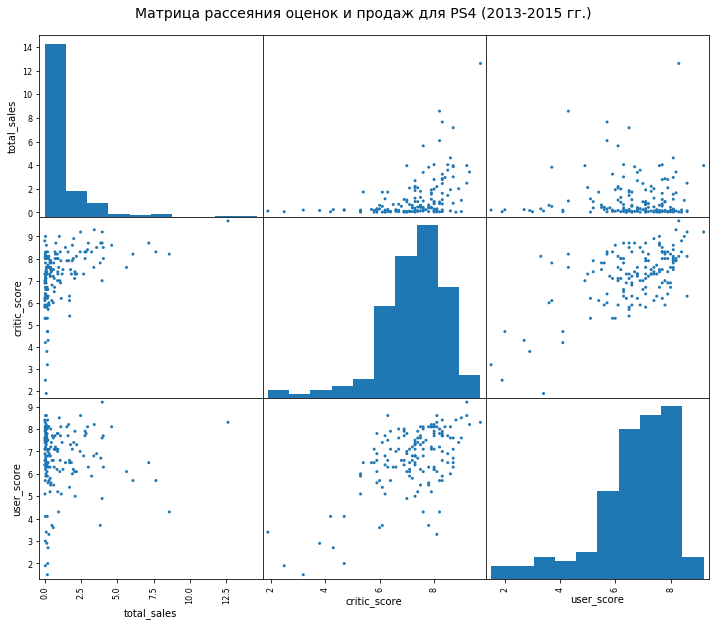

In [29]:
# приведём оценки в одну систему
if df_actual['critic_score'].max() > 10:
    df_actual['critic_score'] /= 10
else: 
    print('Шкала оценок уже преобразована')

# матрица рассеяния
show_scatter_matrix(df_actual.query("platform == 'PS4'"), 
                    ['total_sales', 'critic_score', 'user_score'],
                    title='Матрица рассеяния оценок и продаж для PS4 (2013-2015 гг.)')
# матрица корреляции
styled_corr(df_actual.query("platform == 'PS4'"), 
            ['total_sales','critic_score','user_score'])

Как видим, для __PS4__ продажи довольно сильно зависят от оценок критиков (коэффициент 0,4), но при этом очень слаюбо от оценок пользователей. Возможно это связано с тем, что пользователи оценивают игру уже после покупки

Из диаграмм рассеяния видно:
- Игры с оценками ниже 5 как от критиков, так и от пользователей продаются плохо
- Выше этой оценки зависимость от оценок пользователей и критиков разная. Оценённые высоко критиками игры чаще становятся популярными, одннако среди хорошо продаваемых игр встречаются игры с невысокими оценками

Посмотрим на коэффициенты корреляции продаж с оценками для всех платформ

In [30]:
display(Markdown('Коэффициенты корреляции Продаж с Оценками')) 
# формируем таблицу с коэффициентами корреляции
corr_table = {}
for p in p_candidates:
    df_p = df_actual.query("platform==@p")
    corr_table[p] = df_p[['user_score','critic_score']].corrwith(df_p['total_sales'])
# вывод таблицы
(pd.concat(corr_table.values(), keys=corr_table.keys(), axis=1)
    .style.background_gradient(cmap='coolwarm').set_precision(3)
)

Коэффициенты корреляции Продаж с Оценками

,PS4,PC,3DS,XOne,WiiU
user_score,0.0242,-0.125,0.274,-0.0393,0.433
critic_score,0.432,0.22,0.39,0.459,0.384


- Для популярных платформ __PS4__ и __XOne__ оценки критиков сильнее воияют на продажи
Меньше всего влияние их оценок на продажи игр для __PC__
- На менее популярных __PC__, __3DS__	и __WiiU__ оценки пользователей влияют сильнее.
- Для __WiiU__ сильнее влияние оценок пользователей, нежели критиков

Посмотрим на диаграммы рассения этих параметров отдельно для популярных платформ и для менее популярных

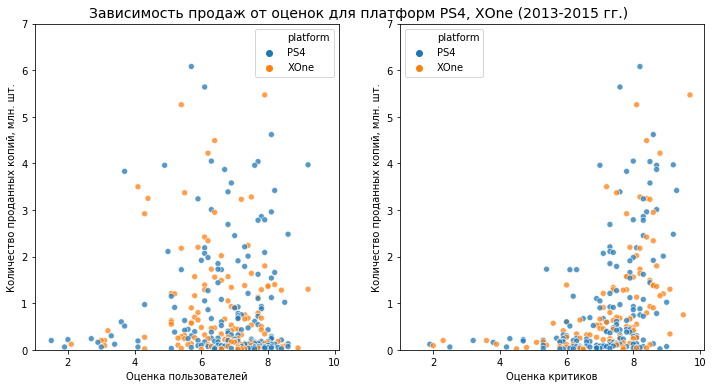

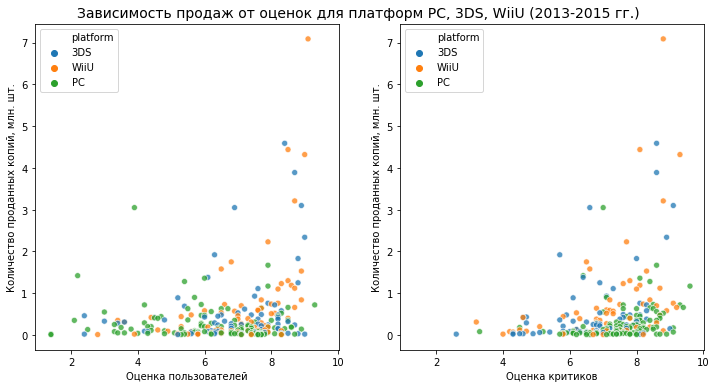

In [31]:
# функция построения диаграмм рассеяния
def show_sales_to_score_scatter(platforms_list, title='Зависимость продаж от оценок для платформ', ylim=None):
    ''' Функция строит диаграммы рассеяния для платформ, названия которых переданы в platforms_list
    '''

    _, (ax_u, ax_c) = plt.subplots(1,2, sharex=True, figsize=(12,6), 
            gridspec_kw={"width_ratios": (.5, .5)})#, "height_ratios": (.5, .5)

    sns.scatterplot(data=df_actual.query("platform in @platforms_list"), 
                    ax=ax_c, x='critic_score', y='total_sales', 
                    hue='platform', alpha=0.75);
    sns.scatterplot(data=df_actual.query("platform in @platforms_list"), 
                    ax=ax_u, x='user_score', y='total_sales', 
                    hue='platform', alpha=0.75);
    
    ax_c.set(ylim=ylim, 
        xlabel = 'Оценка критиков',
        ylabel = 'Количество проданных копий, млн. шт.'
    )
    ax_u.set(ylim=ylim, 
        xlabel = 'Оценка пользователей',
        ylabel = 'Количество проданных копий, млн. шт.'
    );

    plt.suptitle(title, y = 0.92, fontsize=14)

# Выводим диаграммы
show_sales_to_score_scatter(['PS4','XOne'], ylim=(0,7),
    title='Зависимость продаж от оценок для платформ PS4, XOne (2013-2015 гг.)')
show_sales_to_score_scatter(['PC','3DS', 'WiiU'],
    title='Зависимость продаж от оценок для платформ PC, 3DS, WiiU (2013-2015 гг.)')

Диаграммы для популярных платформ схожи

Для менее популярных оценки критиков чаще более высокие, чем оценки пользователей, возможно это связано с тем, что данные неполные, в датасете могут быть не представлены низкие оценки критиков

## Распределение продаж игр по жанрам

Построим столбчатую диаграмму с рапределением продаж игр по жанрам

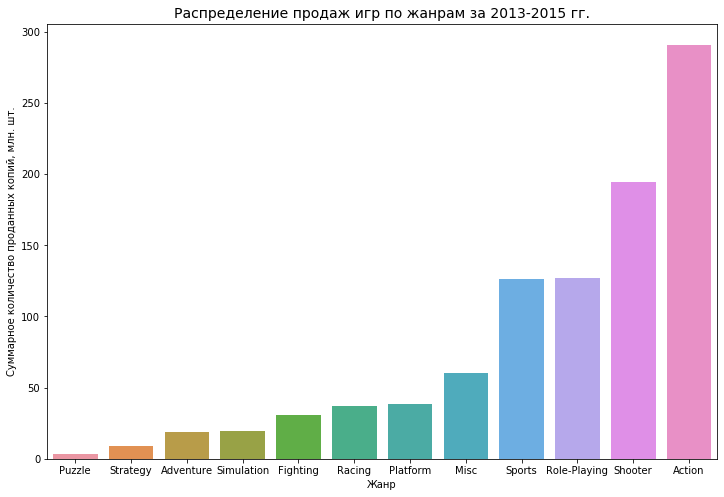

In [32]:
_, ax = plt.subplots()
sns.barplot(data = df_actual, x='genre', y='total_sales', estimator=sum, ci=None,
    order=df_actual.groupby('genre')['total_sales'].sum().sort_values().index);
ax.set(title = 'Распределение продаж игр по жанрам за 2013-2015 гг.',
    xlabel = 'Жанр', ylabel = 'Суммарное количество проданных копий, млн. шт.'
);

- Самые прибыльные жанры - _Action_, _Shooter_, _Sports_, _Role-Playing_
- Особенно выделяется один жанр с высокими продажами - _Shooter_
- Очень сильно выделяются по низким продажам: _Adventure_, _Puzzle_, _Strategy_.  

# Портрет пользователя каждого региона

Для вывода Топ-5 используем вспомогательную функцию, которая будет работать с датасетом df_actual, как с глобальной переменной

In [33]:
def plots_for_regions(by, by_name='', top_n=1, top_title='Топ по регионам'):
    ''' Функция выводит общее распределение продаж по каждому региону в разбивке по параметру 'by'
    упорядоченное по возрастанию суммарных продаж, выводит n самых высоких значений продаж 

    Параметры:
        by : str - название столбца, для которого определяется топ
        by_name : str - текстовая метка этого столбца для графика
        top_n : int - количество позиций топа
        top_title : str - заголовок графика c топом
    '''
    
    # общая сводная таблица с суммарными продажами по регионам 
    region_sales = (df_actual.groupby(by)[['na_sales','eu_sales','jp_sales','total_sales']]
        .sum().sort_values(by='total_sales').drop('total_sales', axis=1)
    )
    
    regions = ["Северная Америка (NA)","Европа (EU)","Япония (JP)"]
    cols    = ['na_sales','eu_sales','jp_sales']
    colors =  ['tab:blue', 'tab:orange','tab:green']

    # график общего распределения
    ax = region_sales.plot(kind='bar', rot=0, figsize=(12,8), grid=True)
    ax.legend(labels=regions, title='регион')
    ax.set( title = 'Распределение продаж игр в разных регионах за 2013-2015 гг. ('+by_name+')',
            xlabel = by_name, ylabel = 'Суммарное количество проданных копий, млн. шт.'
    );
    plt.show()
    
    # вывод топа
    xlim = 1.05*region_sales.max().round().max()
    
    _, ax = plt.subplots(3, figsize=(12,10))
    for i in range(len(cols)):
        #ax[i] = (region_sales.sort_values(by=cols[i])[cols[i]].tail(n)
        #        .plot(kind='barh', grid=True, color=colors[i]))
        r = region_sales.sort_values(by=cols[i])[cols[i]].tail(top_n)
        ax[i].barh(range(top_n), list(r), color=colors[i], tick_label=r.index)
        ax[i].set( xlim=(0, xlim), 
            title = regions[i],
            ylabel = by_name
        )
        for index, value in enumerate(list(r.round(1))):
            ax[i].text(value, index, str(value))
    ax[-1].set_xlabel('Суммарное количество проданных копий, млн. шт.')
    plt.suptitle(top_title, y=0.95, fontsize=14)

## Топ-5 платформ

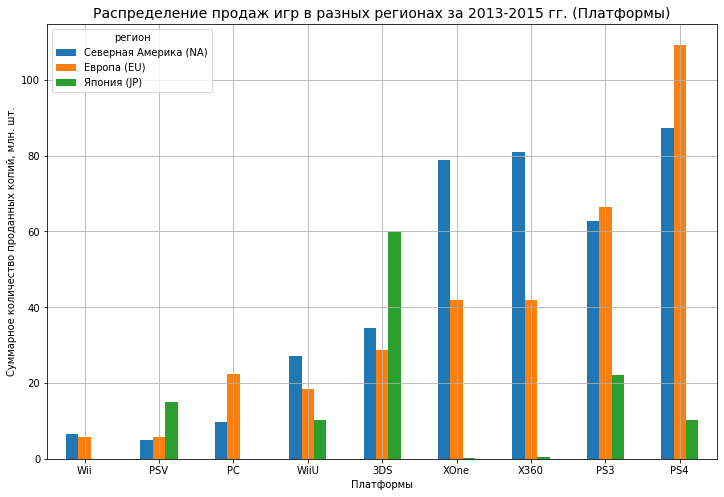

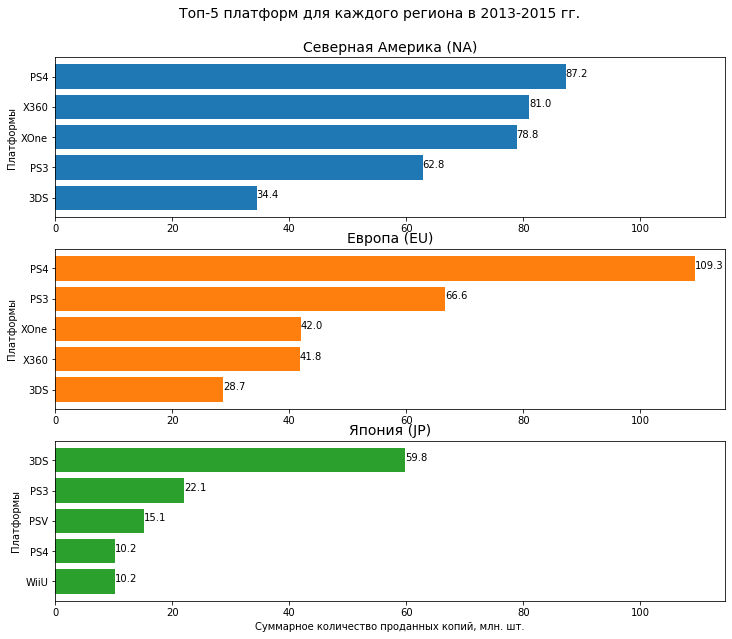

In [34]:
plots_for_regions('platform', by_name='Платформы', top_n=5,
    top_title='Топ-5 платформ для каждого региона в 2013-2015 гг.')

- В Америке все первые строчки рейтинга занимают оба поколения платформ семейста __Play Station__ и __X Box__. Совсем незначительно выделяются в сумме __X Box 360__ и __X Box One__, вероятно потому что, они там и разрабатывались 
- В Европе абсолютное большинство отдают предпочтение платформама семейства __Play Station__, в особенности новой __PS4__, а вот позиции __X Box__ намного слабее
- В целом топ для Америки и Европы состоит из тех же платформ. Заметим, что портативная консоль __3DS__ в обоих регионах вошла в топ
- В Японии пользователи поддерживают отечественных производителей игровых платформ. При этом особое предпочтение отдают портативным консолям. В топе целых три таких платформы: __3DS__, __PSV__ и __WiiU__, первой из которых отдают предпочтение большинство

С этой точки зрения магазину следует ориентироваться на рынок Америки и Европы, там лучше всего представлены наиболее популярные платформы

## Топ-5 жанров

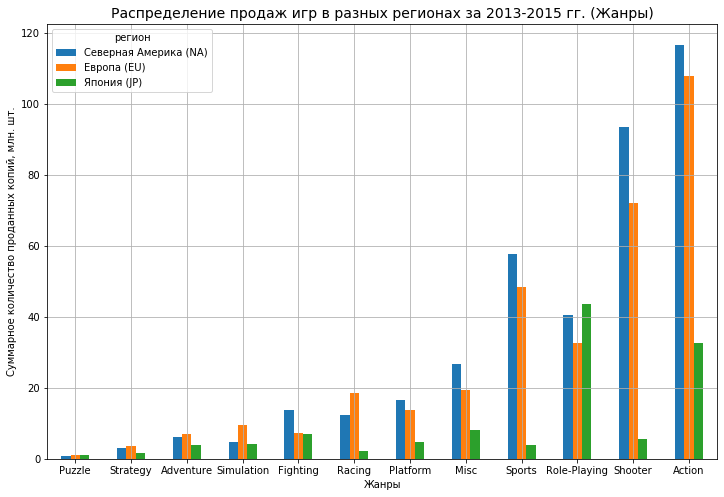

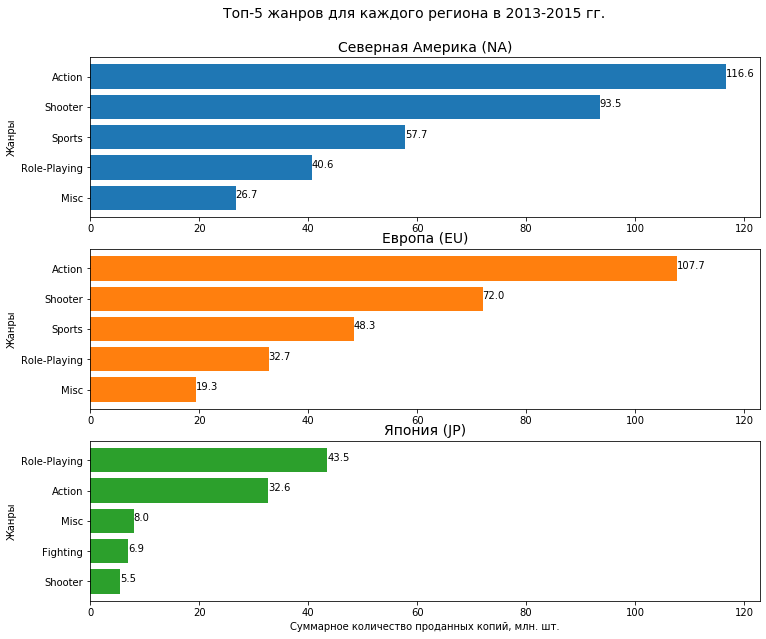

In [35]:
plots_for_regions('genre', by_name='Жанры', top_n=5,
    top_title='Топ-5 жанров для каждого региона в 2013-2015 гг.')

- Топ жанров для Европы и Америки совпадает в точности до позиций, доли продаж тоже примерно одинаковы. Помимо этого этот топ практически совпадает с топом по всем регионам
- В Японии особенно популярны только 2 жанра _Role-Playing_ и _Action_

Магазину следует сделать ставку на игры в жанрах _Action_ и _Shooter_ - они самы продаваемые во всех регионах

## Влияние рейтинга ESRB на продажи в отдельном регионе

,na_sales,eu_sales,jp_sales
rating,,,
E,73.76,71.28,14.74
E10+,52.43,41.23,5.82
T,43.36,34.01,20.04
M,158.07,138.97,13.57


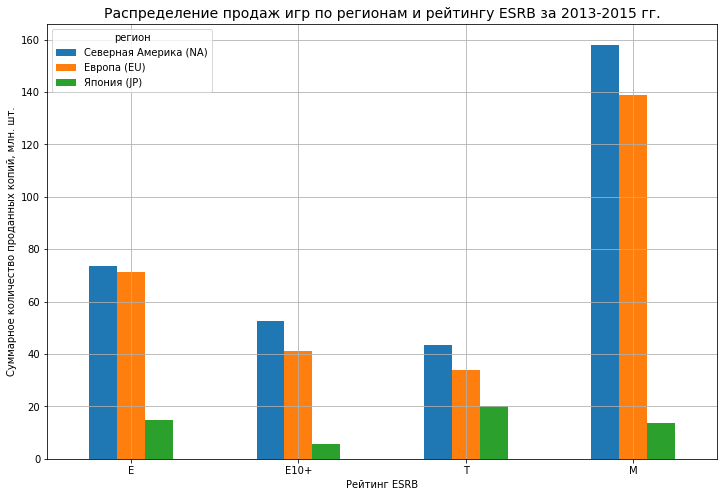

In [36]:
# общая сводная таблица с суммарными продажами по регионам упорядоченная в
# в порядке увеличения допустимого возраста рейтинга
region_sales = (df_actual.groupby('rating')[['na_sales','eu_sales','jp_sales']]
    .sum().reindex(['E', 'E10+', 'T', 'M'])
)

# график общего распределения
ax = region_sales.plot(kind='bar', rot=0, figsize=(12,8), grid=True)
ax.legend(labels=["Северная Америка (NA)","Европа (EU)","Япония (JP)"], title='регион')
ax.set( title = 'Распределение продаж игр по регионам и рейтингу ESRB за 2013-2015 гг.',
        xlabel = 'Рейтинг ESRB', ylabel = 'Суммарное количество проданных копий, млн. шт.'
);
region_sales

В нашу выборку не попали игры с рэйтингом для «_Для детей младшего возраста_» `EC` и «_Только для взрослых_» `AO`. Ожидаемо, что таких игшр немного

По полученным столбчатым диаграммам видим, что рейтинг ESRB влияет на продажи в отдельных регионах. Его влияние на продажи в Европе и Северной Америке практически одинаково, в вот в Японии закономерность снова иная.

- В Европе и Америке самые продаваемые игры - с рейтингом `M` «_Для взрослых_», наименее популярны - с рейтингом `T` «_Подросткам_»
- В Японии же рейтинг `T` «_Подросткам_» напротив самый популярный, меньше всего продаж приходится на игры с рейтингом `E10+` «_Для всех от 10 лет и старше_»

# Проверка гипотез
## Средние пользовательские рейтинги платформ _Xbox One_ и _PC_ одинаковые

Необходимо проверить, одинаковы ли средние пользовательские рейтинги платформ на _генеральных_ совокупностях. 
Сформулируем нулевую и альтернативную гипотезы. 

- **H0** (Нулевая гипотеза): _Средние пользовательские рейтинги платформ Xbox One и PС **равны**_
- **H1** (Альтернативная гипотеза) : _Средние пользовательские рейтинги платформ Xbox One и PС **различаются**_

Проверим нулевую гипотезу с помощью T-теста.

Посмотрим на статистики столбца оценок пользователей для этих платформ

In [37]:
# генерируем описательную статистику и для обеих платформ и объединяем в одну таблицу
pd.concat({
    'XOne': df_actual.query("platform == 'XOne'")['user_score'].describe(),
    'PC': df_actual.query("platform == 'PC'")['user_score'].describe()
}, axis=1).round(1)

,XOne,PC
count,116.0,113.0
mean,6.5,6.3
std,1.3,1.7
min,2.1,1.4
25%,5.8,5.4
50%,6.7,6.7
75%,7.3,7.6
max,9.2,9.3


Оценим _p-value_ - меру вероятности того, что наблюдаемая разница могла возникнуть просто по случайному стечению обстоятельств.
Критический уровень статистической значимости $\alpha$ возьмёи равныи `0.05`. Для оценки используем метод `ttest_ind` из модуля `stats` библиотеки `scipy`. 

Поскольку стандартные отклонения выборок отличаются не сильно и размеры выборок почти одинаковы, то будем считать дисперсии равными `equal_var = True`.

In [38]:
alpha = .05 # критерий значимости

# p-значение
pvalue = st.ttest_ind(df_actual.query("platform == 'XOne'")['user_score'].dropna(), 
                      df_actual.query("platform == 'PC'")['user_score'].dropna(),  
).pvalue
# вывод
display(Markdown('p-значение:  {:.2%}'.format(pvalue)))

if pvalue > alpha:
    display(Markdown("Принимаем гипотезу: \n\
            **Средние пользовательские рейтинги платформ Xbox One и PС равны**")) 
else:
    display(Markdown("Принимаем гипотезу: \n\
            **Средние пользовательские рейтинги платформ Xbox One и PС различаются**"))

p-значение:  31.33%

Принимаем гипотезу: 
            **Средние пользовательские рейтинги платформ Xbox One и PС равны**

Такое _p-value_ означает, что вероятность получить такое же, как в наших выборках, или большее различие средних значений на генеральной совокупности _случайно_ равна примерно 30%. Это большая вероятность, чтобы делать вывод о значимом различии между средними. Поэтому нулевую гипотезу необходимо **принять**.

## Средние пользовательские рейтинги жанров _Action_ и _Sports_ разные

Необходимо проверить, одинаковы ли средние пользовательские рейтинги жанров на _генеральных_ совокупностях. 
Сформулируем нулевую и альтернативную гипотезы. 

- **H0** (Нулевая гипотеза): _Средние пользовательские рейтинги жанров Action и Sports **равны**_
- **H1** (Альтернативная гипотеза) : _Средние пользовательские рейтинги жанров Action и Sports **различаются**_

Проверим нулевую гипотезу с помощью T-теста.

Посмотрим на статистики столбца оценок пользователей для этих жанров

In [39]:
# генерируем описательную статистику и для обеих платформ и объединяем в одну таблицу
pd.concat({
    'Action': df_actual.query("genre == 'Action'")['user_score'].describe(),
    'Sports': df_actual.query("genre == 'Sports'")['user_score'].describe()
}, axis=1).round(1)

,Action,Sports
count,306.0,122.0
mean,6.9,5.2
std,1.3,1.7
min,2.4,1.4
25%,6.4,4.1
50%,7.2,5.4
75%,7.7,6.3
max,9.1,8.8


Оценим _p-value_. Критический уровень статистической значимости $\alpha$ возьмёи равныи `0.05`. 
Будем считать дисперсии равными `equal_var = True`.

In [40]:
alpha = .05 # критерий значимости

# p-значение
pvalue = st.ttest_ind(df_actual.query("genre == 'Action'")['user_score'].dropna(), 
                      df_actual.query("genre == 'Sports'")['user_score'].dropna(),
                      equal_var = False).pvalue
# вывод
display(Markdown('p-значение:  {:.2%}'.format(pvalue)))

if pvalue > alpha:
    display(Markdown("Принимаем гипотезу: \n\
            **Средние пользовательские рейтинги жанров Action и Sports равны**")) 
else:
    display(Markdown("Принимаем гипотезу: \n\
            **Средние пользовательские рейтинги жанров Action и Sports различаются**"))

p-значение:  0.00%

Принимаем гипотезу: 
            **Средние пользовательские рейтинги жанров Action и Sports различаются**

_p-value_ очень близко к 0. Фактически это означает нулевую вероятность получить такое же, как в наших выборках, или большее различие средних значений _случайно_. Поэтому нулевую гипотезу необходимо **отвегрнуть**.

# Общий вывод

В процессе работы с данными были обнаружены проблемы в данных названиях игр: часть пар значений игра-платформа встречались несколько раз из-за того, что продажы по разным регионам были записаны в разные строки, или пурисутсвовали другие комментарии. Их доля незначительна, но следует обратить внимание заказчика на эту проблему


**По итогам исследования сделаны следующие основные выводы**:
- В среднем платформы появляются и исчезают в течение 10 лет
- Актуальный период для анализа данных о продажах игр: c 2013 по 2015 год.
- Игры с оценками ниже 5 как от критиков, так и от пользователей продаются плохо
- Игры оценённые высоко критиками игры чаще становятся популярными

- В качестве потенциально прибыльных платформ необходимо рассмотреть __PS4__ и __XOne__
- Для расширения ассртимента магазина стоит отбрасывать __3DS__, __WiiU__, __PC__ 

- Магазину "Стримчик" следует ориентироваться на рынок Америки и Европы, 
- Сделать приоритет на продаже игр в жанрах _Action_ и _Shooter_ - они самые продаваемые

Проверка гипотез показала:
- Скорее всего Средние пользовательские рейтинги платформ _Xbox One_ и _PC_ одинаковые
- С очень большой вероятностью Средние пользовательские рейтинги жанров Action и Sports различаются